# Import Python Modules

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

## Approach
In the R files, both regression and tree models were considered, and the best model found so-far was a regression model.  The tree model with the lowest cross-validation error on the training data did not perform nearly as well, but was a very simple model.  Here some more advanced methods are explored.

# Read in Data
Some initial preprocessing was done in the R files:
* Replaced blanks with NAs (NaN in df below)
* Moved the reponse variable (revenue) to the first field
* Replaced some outliers with NAs

In [2]:
df = pd.read_csv('dataCleanNoOutlier.csv')
# Drop the Week column, same info is captured in weekno
df = df.drop('Week', 1)
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
0,178480,1,1,0,987718,983958.0000,31589,4715,105901,1519,...,198063.75,574369156,10.084391,3717184,0.000519,23343103440,25,0.822984,2245432996,10.766082
1,185390,2,1,0,660136,907388.9167,30428,4540,108652,1589,...,196355.00,600740100,10.106836,4137156,0.000492,21755266688,36,0.748511,8690900625,11.442771
2,178130,3,1,0,604606,852862.4167,30715,4417,119398,1595,...,194301.80,664144441,10.157005,10569001,0.000308,22414206939,49,0.663123,42966656656,12.241845
3,185020,4,1,0,560656,851885.3333,31632,4372,134819,1606,...,196355.00,679540624,10.168464,37601424,0.000163,21358244109,64,0.568065,4117917241,11.069307
4,170950,5,1,0,326112,827164.4167,NaN,4431,115865,1522,...,216089.00,581533225,10.090589,3069504,0.000571,NaN,81,0.464723,2996248644,10.910313


# Preprocessing
### Repeat Scaling in Python
As was done in R, variables are rescaled to be on the interval [0, 1]
(This is done primarily for the sake of having a clear sequence of steps to perform when testing new data)

*Note: sklearn also has built-in scale functions, that work somewhat differently: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html*

In [3]:
def rescale(x):
    '''
    Rescale a vector x such that all values lie on the interval [0, 1]
    x: an np.array
    '''
    x = x - np.min(x)
    x = x / np.max(x)
    return x

# Test
x = np.array([4, 3, 9, 1, 7, 11])
rescale(x)

array([ 0.3,  0.2,  0.8,  0. ,  0.6,  1. ])

In [4]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

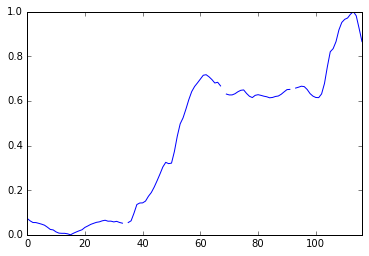

In [5]:
# Examine a column to verify that transformation was correct
df['displaylag'].plot();

### Normalizing Right-Skewed Distributions
The details of how these exponents were found are provided in `nuggetAnalysis3.R`

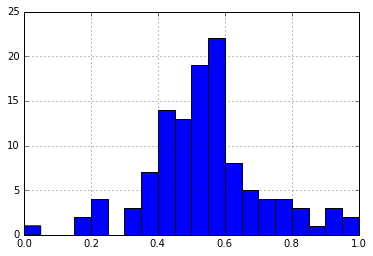

In [6]:
# Transform each of the following by their optimal exponential transform
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['socialpostimp'].hist(bins = 20);

In [7]:
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['Fbpostimp'] = df['Fbpostimp'] ** 0.33
df['Fbpostimplag'] = df['Fbpostimplag'] ** 0.29
df['Fblikes'] = df['Fblikes'] ** 0.60
df['Fbengage'] = df['Fbengage'] ** 0.44
df['Twpostimp'] = df['Twpostimp'] ** 0.29

Rescale again so new transformed values also distributed over [0, 1]:

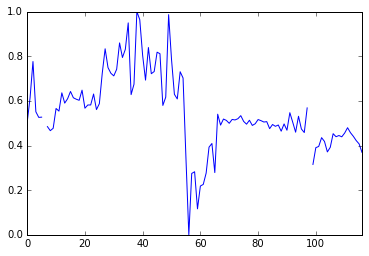

In [8]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

# Verify
df['Twpostimp'].plot();

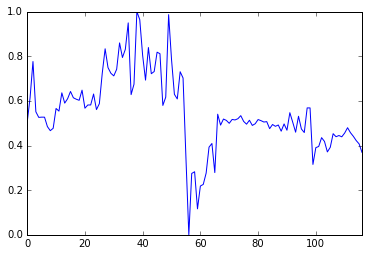

In [9]:
df.fillna(method = 'ffill', axis = 0, inplace = True)
df.fillna(method = 'bfill', axis = 0, inplace = True)
df['Twpostimp'].plot();

## Parse Data into Train and Test Sets

In [10]:
df.shape

(117, 57)

In [11]:
X = df.ix[:, 1:58]
y = df.ix[:, 0]

# Now split each into testing and training sets
# Ideally, we would stratify the data, but there are too few data in this
# sample 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 11)
X_train.head()

,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,organicnew,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
110,111,1,0,0.504781,0.965312,0.442370,0.614227,0.370969,0.487954,0.518850,...,0.139337,0.451624,0.586457,0.252645,0.270984,0.037116,0.044395,0.619658,0.004636,0.585025
28,29,0,0,0.060270,0.060954,0.481003,0.601989,0.171516,0.268069,0.594431,...,0.237948,0.529510,0.658001,0.516228,0.115217,0.044957,0.402516,0.168439,0.136871,0.846416
51,52,1,0,0.402618,0.373283,0.595848,0.993881,0.534335,0.441127,0.834825,...,0.827902,0.797692,0.868410,0.456901,0.139625,0.645507,0.005549,0.942728,0.041569,0.754387
56,57,1,0,0.420757,0.605760,0.645554,0.648649,0.387652,0.377672,0.917639,...,0.603594,0.897286,0.935580,0.035775,0.736521,0.287995,0.029597,0.732362,0.000000,0.000000
39,40,1,0,0.201701,0.142477,0.703339,0.789648,0.341876,0.415677,0.707983,...,0.727319,0.652310,0.760441,0.265818,0.258958,0.478024,0.715871,0.784032,0.776346,0.980449


Hold out ~25% or 29 rows of data for the test set.

# Linear Regression Models
Recreate the best linear model found in R, and explore further

In [12]:
lr_clf = LinearRegression()
modTr_lm2 = [
    'highseason', 'holiday', 'brandpaid', 'brandclicks', 'organicnew', 
    'youtube', 'youtubelag', 'socialpostlag', 'Fbengage', 'fbengagelag', 
    'TWimpLag', 'emailopen', 'blogvisits', 'blognewusers', 'blogsignup']
lr_clf.fit(X = X_train.ix[:, modTr_lm2], y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Compute SSE (sum of squared error)

NOTE: sklearn models had a `residues_` member, but it is deprecated, and will be removed in 0.19, so a function is provided here

In [13]:
def sse(mod, X, y):
    predictions = mod.predict(X)
    sq_error = [
        (pred - actual) ** 2 for (pred, actual) in zip(predictions, y)]
    RSS = sum(sq_error)
    
    return(RSS)

In [14]:
sse(lr_clf, X_test.ix[:, modTr_lm2], y = y_test)

7685302034.6259289

*Note that the value here of 7.6853e+9 differs slightly from the value found in R: 7.6168e+9; this is because we had to fill the NaN values for sklearn's LinearRegression classifier, and because the data randomly selected for the test or training sets will differ*

In [15]:
currentBest = { 
    'model': 'lr_clf',
    'sse': sse(lr_clf, X_test.ix[:, modTr_lm2], y = y_test) }

### Explore Ridge and Lasso Regression

In [16]:
pipe_ridge = Pipeline([('clf', Ridge(random_state = 11))])

alpha_range = np.linspace(0, 10, num = 30)
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

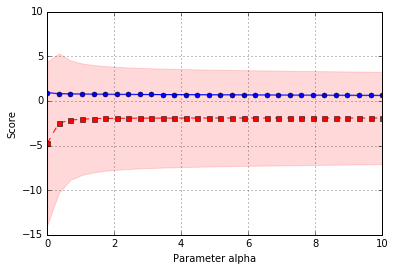

In [18]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
#plt.legend(loc = 'lower left');
#plt.xscale('log');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
#plt.ylim([-2, -1.9]);
plt.show();

In [19]:
ridge_clf = Ridge(alpha = 8, random_state = 11)
ridge_clf.fit(X_train, y_train)
sse(ridge_clf, X_test, y_test)

4972864197.2487793

Compare to best so far:

In [20]:
currentBest

{'model': 'lr_clf', 'sse': 7685302034.6259289}

Wow. That is a substantial improvement already.  Update currentBest

In [21]:
currentBest = { 'model': 'ridge_clf',
                'sse': sse(ridge_clf, X_test, y_test) }

The best model found in R had an SSE of 7.6168e+9, or an average error of $16,206.  How does the new best model compare?

In [22]:
print 'Avg. error: $%.2f' %np.sqrt(currentBest['sse'] / len(y_test))
print 'Std Dev. of revenue: $%.2f'%np.std(df['revenue'])

Avg. error: $12874.86
Std Dev. of revenue: $23841.97


Lots better! The mean error now is almost half the standard deviation... but maybe we can do better still....?

### Lasso Regression

In [23]:
pipe_lasso = Pipeline([(
            'clf', Lasso(random_state = 11, max_iter = 100000))])
alpha_range = np.linspace(1, 100, 30)
train_scores, test_scores = validation_curve(estimator = pipe_lasso,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

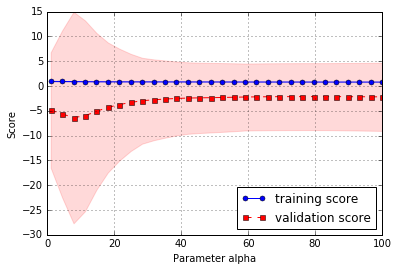

In [24]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
#plt.xscale('log');
plt.legend(loc = 'lower right');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
#plt.ylim([-4, -1]);
plt.show();

In [25]:
lasso_clf = Lasso(alpha = 80, random_state = 11)
lasso_clf.fit(X_train, y_train)
sse(lasso_clf, X_test, y_test)

5330949016.2342567

In [26]:
currentBest

{'model': 'ridge_clf', 'sse': 4972864197.2487793}

The ridge regession model is somewhat better.  Lasso is helpful in any case, as it helps to determine which of the predictors are actually useful, as it drives those predictors' coefficients that are less useful to 0.  This is useful if we are trying to prioritize which predictors to continue to make use of or invest in.  To observe:

In [27]:
zip(df.columns.values, lasso_clf.coef_)
# Note: the first predictor is the intercept, not "revenue", the above 
# syntax is just a quick and dirty way to do this

[('revenue', -339.7471362239304),
 ('weekno', -0.0),
 ('highseason', -28349.553504529638),
 ('holiday', 0.0),
 ('displayimp', 45890.543238444858),
 ('displaylag', -0.0),
 ('brandpaid', 20390.644016701979),
 ('brandclicks', -0.0),
 ('nonbrandpaid', -5360.1004330457345),
 ('nonbrandclicks', 0.0),
 ('organicnew', 0.0),
 ('youtube', 6428.1250551517887),
 ('youtubelag', 0.0),
 ('socialpostimp', 0.0),
 ('socialpostlag', 0.0),
 ('socialimp', 0.0),
 ('socialimplag', 0.0),
 ('fbposts', -0.0),
 ('Fbpostimp', 0.0),
 ('Fbpostimplag', 0.0),
 ('Fbpageimp', 0.0),
 ('Fblikes', 22451.831385062094),
 ('Fbengage', 0.0),
 ('fbengagelag', -147.45467615459694),
 ('twposts', -0.0),
 ('Twpostimp', 0.0),
 ('TWimpLag', -0.0),
 ('twengage', -0.0),
 ('twengagelag', 0.0),
 ('emailsent', 25690.803372415499),
 ('emailopen', 0.0),
 ('emailclick', -33670.692056009713),
 ('blogvisits', 0.0),
 ('blognewusers', 0.0),
 ('blogrefer', 15722.651849020764),
 ('blogrefernew', 5594.9899343257493),
 ('blogsignup', -0.0),
 ('auto

# Tree Models Revisited

In [28]:
gs = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state = 11),
    param_grid = [{ 'max_depth': [1, 2, 3, 4, 5, None],
                    'min_samples_split': [1, 2, 3, 4, 8],
                    'min_samples_leaf': [1, 2, 3, 4, 8, 10] }],
    cv = 10,
    n_jobs = -1)

In [29]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=11,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_split': [1, 2, 3, 4, 8], 'max_depth': [1, 2, 3, 4, 5, None], 'min_samples_leaf': [1, 2, 3, 4, 8, 10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
print gs.best_params_

{'min_samples_split': 1, 'max_depth': 4, 'min_samples_leaf': 8}


In [31]:
tree_clf = gs.best_estimator_
tree_clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=8, min_samples_split=1,
           min_weight_fraction_leaf=0.0, presort=False, random_state=11,
           splitter='best')

In [32]:
sse(tree_clf, X_test, y_test)

11492526797.831745

Not an improvement, but examine how the model uses the predictors.

In [33]:
zip(X_test.columns.values, tree_clf.feature_importances_)

[('weekno', 0.0),
 ('highseason', 0.0),
 ('holiday', 0.0),
 ('displayimp', 0.0),
 ('displaylag', 0.0),
 ('brandpaid', 0.48088552123869388),
 ('brandclicks', 0.0),
 ('nonbrandpaid', 0.027227972855735957),
 ('nonbrandclicks', 0.0),
 ('organicnew', 0.0),
 ('youtube', 0.0),
 ('youtubelag', 0.0),
 ('socialpostimp', 0.0),
 ('socialpostlag', 0.0),
 ('socialimp', 0.0),
 ('socialimplag', 0.10517011136998491),
 ('fbposts', 0.0),
 ('Fbpostimp', 0.0),
 ('Fbpostimplag', 0.0),
 ('Fbpageimp', 0.0),
 ('Fblikes', 0.0),
 ('Fbengage', 0.064716150634849132),
 ('fbengagelag', 0.0),
 ('twposts', 0.0),
 ('Twpostimp', 0.0),
 ('TWimpLag', 0.0),
 ('twengage', 0.0),
 ('twengagelag', 0.0),
 ('emailsent', 0.023462989849499731),
 ('emailopen', 0.0),
 ('emailclick', 0.0),
 ('blogvisits', 0.0),
 ('blognewusers', 0.0),
 ('blogrefer', 0.0),
 ('blogrefernew', 0.0),
 ('blogsignup', 0.0),
 ('autoenroll', 0.0),
 ('socialperson', 0.0),
 ('promoteposts', 0.0),
 ('learner', 0.0),
 ('rev1weekAgo', 0.22285674213716675),
 ('rev2

There have been a lot of breakthroughs in recent ML by making ensembel tree methds to boost their power, such as AdaBoost and Random Forests used here.  See if an ensemble tree classifier can improve the results.

In [34]:
forest_clf = RandomForestClassifier(criterion = 'entropy', 
                                    n_estimators = 50, 
                                    max_depth = 5,
                                    min_samples_leaf = 7,
                                    random_state = 11, 
                                    n_jobs = -1)

In [35]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=11, verbose=0, warm_start=False)

In [36]:
sse(forest_clf, X_test, y_test)

11034464500

This is an improvement over the simple tree model, but as in R, the tree models pale in comparison with the regression models for this data set.

In [37]:
currentBest

{'model': 'ridge_clf', 'sse': 4972864197.2487793}